In [130]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
import seaborn as sns
from numpy.linalg import norm
from numpy.linalg import inv
import pandas as pd

# 1(a)

In [131]:
# square dimension
m=10

# generate mxm symmetric matrix
A = np.random.randn(m,m)
A = (A+A.T)/2

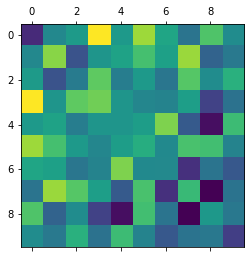

In [132]:
# visualize the symmetric matrix
plt.matshow(A)

In [133]:
# check the determinant
np.linalg.det(A)

-547.998773555943

In [134]:
# calculate eigenvalues and eigenvectors
w_true,v_true = np.linalg.eig(A)

# 1(b)

In [135]:
def power_iteration(A, iterations):
    
    '''Finds the largest eigenvalue of matrix A.'''
    
    w_true,v_true = np.linalg.eig(A)
    w0_true = w_true[np.argmax(np.abs(w_true))]
    
    # set up plot
    plt.figure(figsize=[10,6])
    
    # first guess at eigenvector
    b = np.random.randn(A.shape[1])
    b = b / norm(b)
    
    # power iterate
    for i in np.arange(0,iterations,1):
        b = A@b / np.linalg.norm(A@b)
        
        # use rayleigh quotient to compute eigenvalue
        w = b.T.conjugate()@A@b/(b.T.conjugate()@b)
        
        #plot eigenvalue approaching true eigenvalue
        plt.scatter(i,np.abs(w0_true-w), c='C0', alpha=.3)
        if i == iterations-1:
            plt.scatter(i,np.abs(w0_true-w), c='C0')
            
    plt.title('Power Iteration - Largest Eigenvalue Error')
    plt.yscale('log');
    plt.ylabel('Absolute Error \n (Log Scale)'); plt.xlabel('Iterations');
    
    return w,b

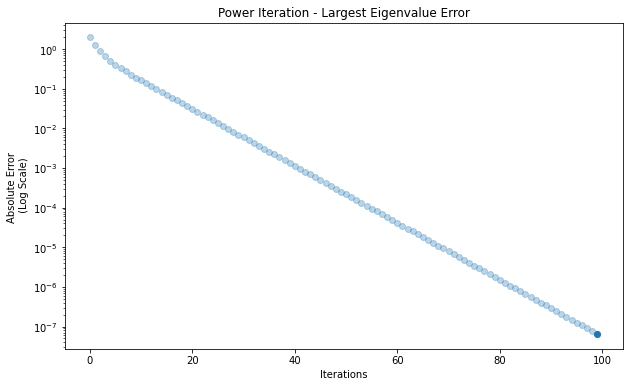

In [136]:
w,b = power_iteration(A, iterations=100)

Error in the iteration method drops exponentially as seen in the Log-Linear plot above, until settling around $ 10^{-14} $. Likely no longer dropping due to roundoff at floating point precision.

# 1(c)

In [137]:
def rayleigh_quotient_iteration(A, iterations=10):
    
    '''Finds the eigenvalues of matrix A.'''
    
    w_true,v_true = np.linalg.eig(A)
    w0_true = w_true[np.argmax(np.abs(w_true))]
    
    # first guess at eigenvector
    b = np.random.rand(A.shape[0])
    b = b / norm(b)

    q,r = np.linalg.qr(A)
    
    # first guess at eigenvalue
    w = b.T.conjugate()@A@b/(b.T.conjugate()@b)

    # Rayleigh Quotient iteration
    for i in np.arange(0,iterations,1):

        b = inv((A - w*np.identity(A.shape[0])))@b / norm(inv((A - w*np.identity(A.shape[0])))@b)
        w = b.T.conjugate()@A@b/(b.T.conjugate()@b)

    return w,b

In [138]:
w,b = rayleigh_quotient_iteration(A)

In [139]:
w0_true = w_true[min(range(len(w_true)), key=lambda j: abs(w_true[j]-w))]

In [140]:
w

0.5107494312046412

In [141]:
w0_true

0.5107494312046413

Simply guessing at the eigenvectors and performing Rayleigh Quotient Iteration converges cubically to a single eigenvalue and vector. This does not give all 10 eigenvalues, and randomly guessing until all 10 are found would be inefficient.

I will have to improve the inital guesses to improve the convergance. I have found that the algorithm to rayleigh quotient iteration for finding all eigenvalues is called the subspace iteration.

This algorithm subtracts the components of all other eigenvectors before performing the QR and performing the rayleigh quotient iteration process. This causes the algorithm to converge to each eigenvalue one after another.

In [142]:
def subspace_iteration(A, iterations=20):
    
    '''Finds the eigenvalues of matrix A.'''
    
    w_found = []
    b_found = []
    
    for j in np.arange(0,len(w_true),1):
        # guess at eigenvector
        if j>0:
            b = np.random.rand(A.shape[0])
            for b_ in b_found:
                b = b - b_.T.conjugate()@np.outer(b,b_)
            b = b / norm(b)
        else:
            b = np.random.rand(A.shape[0])
            b = b / norm(b)
            
        q,r = np.linalg.qr(A)

        # first guess at eigenvalue
        w = b.T.conjugate()@A@b/(b.T.conjugate()@b)

        # Rayleigh Quotient iteration
        for i in np.arange(0,iterations,1):

            b = inv((A - w*np.identity(A.shape[0])))@b / norm(inv((A - w*np.identity(A.shape[0])))@b)
            w = b.T.conjugate()@A@b/(b.T.conjugate()@b)
            
        # save eigenvalue/vector
        w_found.append(w) 
        b_found.append(b)
    
    return w_found,b_found

Eigenvalues found by subspace iteration:

In [143]:
w,b = subspace_iteration(A)
np.round(w,5).tolist()

[-0.55708,
 -1.17293,
 2.17455,
 2.5902,
 -2.89404,
 0.51075,
 2.76226,
 3.98255,
 -3.66611,
 -2.49774]

Eigenvalues found by numpy "eig":

In [144]:
np.round(w_true,5).tolist()

[-3.66611,
 -2.89404,
 -2.49774,
 3.98255,
 2.76226,
 2.5902,
 2.17455,
 -1.17293,
 -0.55708,
 0.51075]

Eigenvalues found by subspace iteration:

In [145]:
b

[array([-0.10482837, -0.35455444,  0.27426841, -0.20005553, -0.11262783,
         0.16272117,  0.57862236,  0.29170461, -0.10988004, -0.5262362 ]),
 array([-0.09090234,  0.46809906,  0.69028806, -0.07551388, -0.07971174,
        -0.27087974,  0.29028619, -0.1182482 ,  0.24725441,  0.22651012]),
 array([-0.277617  , -0.47657959,  0.26763497,  0.12976603, -0.00577327,
        -0.59537915, -0.23360194,  0.12263744, -0.39005867,  0.17626051]),
 array([ 0.46377982, -0.29551274,  0.24679055,  0.67804948,  0.18829799,
         0.10943765,  0.19424307, -0.29867689,  0.0497646 ,  0.00873643]),
 array([ 0.5322544 , -0.06273509, -0.10591431, -0.19171006,  0.31715966,
        -0.43847144,  0.04628776,  0.49427399,  0.35426024,  0.00136967]),
 array([-0.01123709,  0.26570507, -0.31562505,  0.37669443, -0.44628073,
        -0.49766235,  0.11803065, -0.07789794,  0.05207417, -0.46713096]),
 array([ 0.1229567 , -0.19035573,  0.29105817,  0.08306001, -0.58877468,
         0.22225562, -0.476937  ,  0.27

Eigenvectors found by numpy "eig":

In [146]:
v_true

array([[-0.5718437 , -0.5322544 ,  0.2426399 , -0.06454577, -0.1229567 ,
         0.46377982,  0.277617  ,  0.09090234,  0.10482837,  0.01123709],
       [-0.10518428,  0.06273509, -0.0822769 , -0.46055959,  0.19035573,
        -0.29551274,  0.47657959, -0.46809906,  0.35455444, -0.26570507],
       [-0.20526513,  0.10591431, -0.23998823, -0.14305657, -0.29105817,
         0.24679055, -0.26763497, -0.69028806, -0.27426841,  0.31562505],
       [ 0.39511476,  0.19171006, -0.03290375, -0.36733688, -0.08306001,
         0.67804948, -0.12976603,  0.07551388,  0.20005553, -0.37669443],
       [ 0.16256473, -0.31715966, -0.50987413, -0.11251784,  0.58877468,
         0.18829799,  0.00577327,  0.07971174,  0.11262783,  0.44628073],
       [ 0.0737661 ,  0.43847144,  0.02642752, -0.19552656, -0.22225562,
         0.10943765,  0.59537915,  0.27087974, -0.16272117,  0.49766235],
       [ 0.22788255, -0.04628776,  0.42866276,  0.09697907,  0.476937  ,
         0.19424307,  0.23360194, -0.29028619

# 1(d)

In [147]:
A = np.random.randn(m,m)

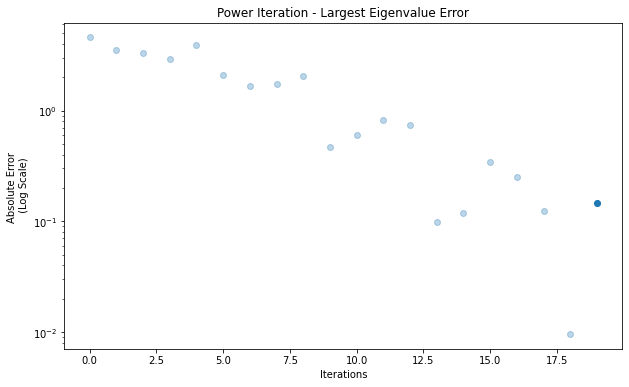

In [148]:
w,b = power_iteration(A, iterations=20)

In [149]:
w_true,v_true = np.linalg.eig(A)

the algorithm does not converge to a good estimate of the largest eigenvalue.

In [150]:
w_true

array([ 3.84815637+0.j        , -2.92148739+0.j        ,
        0.06460766+3.2306625j ,  0.06460766-3.2306625j ,
        0.38764563+1.86163936j,  0.38764563-1.86163936j,
        1.43294956+0.j        , -0.34159546+0.42075668j,
       -0.34159546-0.42075668j, -1.08976402+0.j        ])

In [151]:
w

3.701216361066222

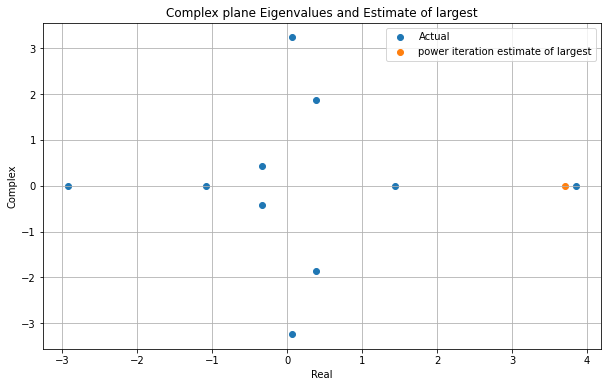

In [152]:
plt.figure(figsize=[10,6])
X = [x.real for x in w_true]
Y = [x.imag for x in w_true]
plt.scatter(X,Y, label='Actual')
plt.scatter(w,0, label='power iteration estimate of largest')
plt.legend(); plt.title('Complex plane Eigenvalues and Estimate of largest')
plt.xlabel('Real'); plt.ylabel('Complex');
plt.grid()
plt.show()

Subspace iterating to find all:

In [153]:
w,b = subspace_iteration(A)

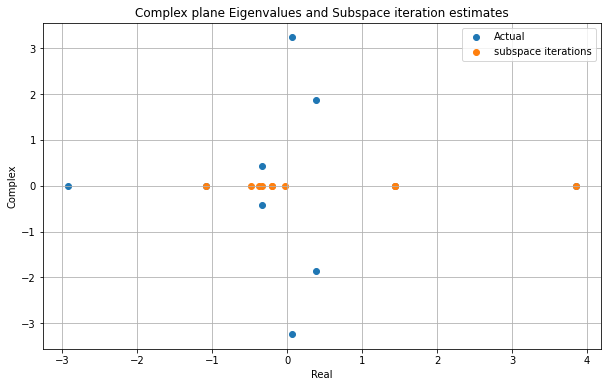

In [154]:
plt.figure(figsize=[10,6])
X = [x.real for x in w_true]
Y = [x.imag for x in w_true]
plt.scatter(X,Y, label='Actual')
plt.scatter(w,[0]*len(w), label='subspace iterations')
plt.legend(); plt.title('Complex plane Eigenvalues and Subspace iteration estimates')
plt.xlabel('Real'); plt.ylabel('Complex');
plt.grid()
plt.show()

The iterative technique fails to find the eigenvalues.

# 2(a)

In [155]:
# Iterate through the cropped images folder finding all files
filelist=[]
for root, dirs, files in os.walk('C:\\Users\\Kelton\\UW\\AMATH584\\Homework\\hw2\\yalefaces_cropped'):
    for file in files:
        #append the file name to the list
        filelist.append(os.path.join(root,file))
        
print('number of images:',len(filelist))

number of images: 272


In [156]:
# Build a list of images from the files
images=[]
for imgfile in filelist:
    images.append(plt.imread(imgfile))

In [157]:
# create a list of all array data from the images
A = []
for image in images:
    A.append(np.reshape(image,(-1,1)))

# create array from data
A = np.array(A).squeeze()
# check the shape of the array, each image is a column
print('A Shape:',A.transpose().shape)
A = A.transpose()

A Shape: (32256, 272)


Create a square correlation matrix:

In [158]:
Acorr = pd.DataFrame(A).corr()

In [159]:
Acorr.shape

(272, 272)

Define power iteration:

In [160]:
def power_iteration_clean(A, iterations):
    
    '''Finds the largest eigenvalue of matrix A.'''
    
    w_true,v_true = np.linalg.eig(A)
    w0_true = w_true[np.argmax(np.abs(w_true))]
    
    # first guess at eigenvector
    b = np.random.randn(A.shape[1])
    b = b / norm(b)
    
    # power iterate
    for i in np.arange(0,iterations,1):
        b = A@b / np.linalg.norm(A@b)
        
        # use rayleigh quotient to compute eigenvalue
        w = b.T.conjugate()@A@b/(b.T.conjugate()@b)
        
    return w,b

In [161]:
w,b = power_iteration_clean(np.array(Acorr), 10)

In [162]:
u,s,v = np.linalg.svd(Acorr)

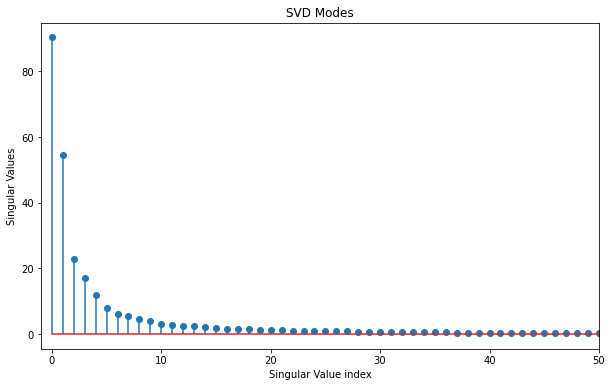

In [163]:
plt.figure(figsize=[10,6])
plt.stem(np.arange(0,s.shape[0],1),s)
plt.xlim(-1,50);
plt.title('SVD Modes'); plt.ylabel('Singular Values')
plt.xlabel('Singular Value index');

leading singular value:

In [164]:
s[0]

90.36480489964875

largest eigenvalue:

In [165]:
w

90.36278433841416

Nearly identical largest singular value and eigenvalue for square correlation matrix of image dataset.

# 2(b)

In [166]:
def randomized_svd(A,p,iterations=3):
    
    '''compute randomized SVD.'''
    
    P = np.random.randn(A.shape[1],p)
    
    # Multiply A by Random matrix P
    Z = A@P
    
    # Power Iterations
    for i in np.arange(0,iterations,1):
        Z = A@(A.T@Z)
        
    # QR Decomp - get orthogonal bases for Z
    Q,R = np.linalg.qr(Z)
    
    # Changes Bases
    Z = Q.T@A

    u,s,v = np.linalg.svd(Z, full_matrices=False)
    # project Q into u
    u = Q@u
    
    return u,s,v

10 randomized vectors in P, then projecting A into P, then recreating SVD with rSVD.

In [167]:
%%timeit
randomized_svd(Acorr, 10)

2.17 ms ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [168]:
%%timeit
np.linalg.svd(Acorr, 10)

7.72 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [169]:
ru,rs,rv = randomized_svd(Acorr,10,2)

In [170]:
ru.shape

(272, 10)

In [171]:
rs.shape

(10,)

In [172]:
rv.shape

(10, 272)

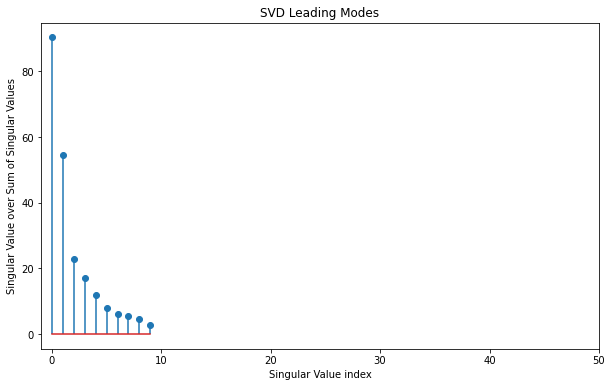

In [173]:
plt.figure(figsize=[10,6])
plt.stem(np.arange(0,rs.shape[0],1),rs)
plt.xlim(-1,50);
plt.title('SVD Leading Modes'); plt.ylabel('Singular Value over Sum of Singular Values')
plt.xlabel('Singular Value index');

# 2(c)

comparing randomized modes to true modes

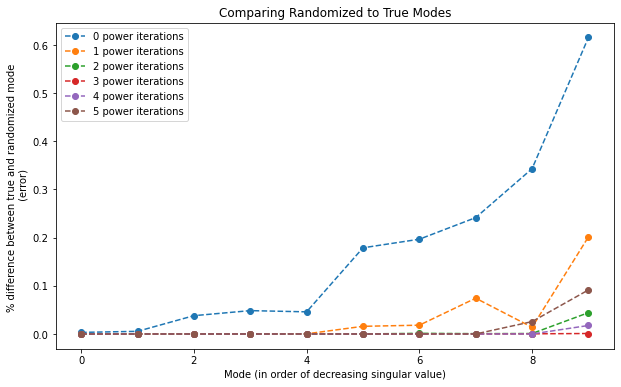

In [174]:
plt.figure(figsize=[10,6])
for i in np.arange(0,6,1):
    ru,rs,rv = randomized_svd(Acorr,10,i)
    plt.plot(np.abs(s[:10]-rs) / s[:10], label=str(i)+' power iterations', ls='--', marker='o')
plt.ylabel('% difference between true and randomized mode \n (error)'); plt.legend()
plt.xlabel('Mode (in order of decreasing singular value)')
plt.title('Comparing Randomized to True Modes');

With more power iterations (expensive computuationally) accuracy of the rSVD improves. Regardless of power iterations, in this case, the first few modes are very close to the true modes.

In [175]:
Bcorr=Acorr.copy()

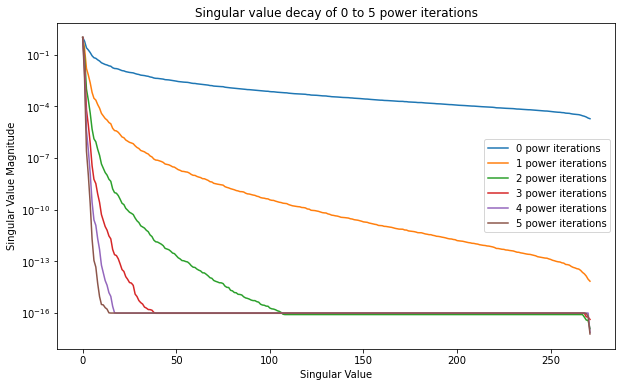

In [182]:
plt.figure(figsize=[10,6])
U,S,V = np.linalg.svd(Acorr,full_matrices=False)
Y=Bcorr
S=S/S[0]
Bcorr=U@np.diag(S)@V
plt.plot(S, label='0 powr iterations')
# power iterationsb
for q in np.arange(1,6,1):
    Y=Bcorr.T@Y
    Y=Bcorr@Y
    Uq,Sq,VTq = np.linalg.svd(Y, full_matrices=False)
    plt.plot(Sq, label=str(q)+' power iterations')
plt.yscale('log'); plt.legend()
plt.title('Singular value decay of 0 to 5 power iterations');
plt.ylabel('Singular Value Magnitude'); plt.xlabel('Singular Value');

Singular values of the matrix already decay quite quickly, so I have put it on a log plot above. I also used a trick found in Steve Brunton's SVD lectures to scale the singular values between 0 and 1 to make a more readable plot demonstrating the increased falloff in singular value decay as you power iterate.